In [1]:
import torch

In [2]:
# Switch to GPU if available for faster calculations
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")  # Use CUDA device
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('GPU not found, using CPU instead.')

Using GPU: NVIDIA GeForce MX230


In [3]:
from elo_guesser.helper_functions import load_dataset
from elo_guesser.helper_functions import elo_range

from elo_guesser.models import complex_network
from elo_guesser.models import train_network

In [4]:
rating_ranges = elo_range.get_rating_ranges()

### Load Analyzed Games

In [5]:
position_type = "boards_mirrors"
path = "../../datasets/"
dataset = load_dataset.load_games(position_type, path)
print("Total Games:", len(dataset))

Total Games: 20000


In [6]:
def modify_dataset(dataset):
    import random

    random.shuffle(dataset)

    total_games = len(dataset)
    test_games = int(total_games * 0.15)

    x_train =[(position.unsqueeze(2).to(device), evaluation.to(device)) for position, evaluation, _ in dataset[:-test_games]]
    y_train = [elo_range.calculate_elo_range(elo).to(device)
               for _, _, elo in dataset[:-test_games]]
    x_test =[(position.unsqueeze(2).to(device), evaluation.to(device)) for position, evaluation, _ in dataset[-test_games:]]
    y_test = [elo for _, _, elo in dataset[-test_games:]]
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = modify_dataset(dataset)

In [7]:
print("Train Games:", len(x_train))
print(x_train[0][0].shape)
print(x_train[0][1].shape)

Train Games: 17000
torch.Size([2, 36, 1, 8, 8])
torch.Size([2, 36, 17])


### Define the Model

In [8]:
def create_model():
    input_size = x_train[0][1].shape[-1]
    lstm_model = complex_network.EloGuesser(input_size, input_channels=1, num_classes=rating_ranges.shape[0])
    learning_rate = 0.001
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
    
    return lstm_model, optimizer

lstm_model, optimizer = create_model()

### Train the model

In [25]:
# CrossEntropyLoss is commonly used for classification problems
# Since this is technically not a classification problem, I'm not sure it's the best choice 
loss_func = torch.nn.CrossEntropyLoss()

loss_graph = train_network.train(lstm_model, x_train, y_train, optimizer, loss_func, num_epochs=20, validation_split=0.15)

Epoch: 1, Validation Loss: 1.9970455308988984
Epoch: 2, Validation Loss: 2.005331994224997
Epoch: 3, Validation Loss: 2.023806258416643
Epoch: 4, Validation Loss: 2.0087308512949478
Epoch: 5, Validation Loss: 2.01030597261354
Epoch: 6, Validation Loss: 2.0051116608170902
Epoch: 7, Validation Loss: 2.0133762620944604
Epoch: 8, Validation Loss: 2.00713953481001
Epoch: 9, Validation Loss: 2.010269019323237
Epoch: 10, Validation Loss: 2.0113691106497074
Epoch: 11, Validation Loss: 2.01006839948542
Epoch: 12, Validation Loss: 2.01382632709017
Epoch: 13, Validation Loss: 2.0087614793870965
Epoch: 14, Validation Loss: 2.0139368907143087
Epoch: 15, Validation Loss: 2.0045451712608338
Epoch: 16, Validation Loss: 2.0163248284657795
Epoch: 17, Validation Loss: 2.020505051612854
Epoch: 18, Validation Loss: 2.02778815535938
Epoch: 19, Validation Loss: 2.0044178016045513
Epoch: 20, Validation Loss: 2.021638775058821


In [9]:
# To free CUDA memory
del x_train, y_train

### Plot the results

In [26]:
from elo_guesser.helper_functions import plot_results

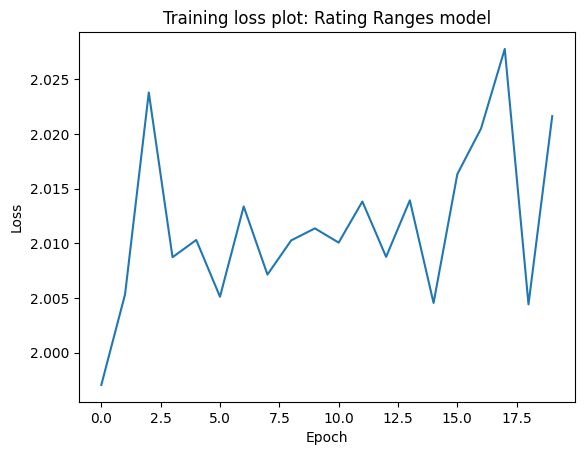

In [27]:
plot_results.plot_loss(loss_graph)

### Test predictions

In [28]:
def get_predictions(lstm_model, x_test):
    predictions = []
    for game in x_test:
        prediction, (_h, _c) = lstm_model.eval()(game)
        prediction = elo_range.guess_elo_from_range(prediction).cpu().detach()
        predictions.append(prediction)
    return predictions

predictions = get_predictions(lstm_model, x_test)

In [30]:
# Flatten the output vectors
y_test = torch.cat(y_test).view(-1)
predictions = torch.cat(predictions).view(-1)

Mean error: 230.19862365722656
50th percentile: 185.3134765625
90th percentile: 492.281982421875


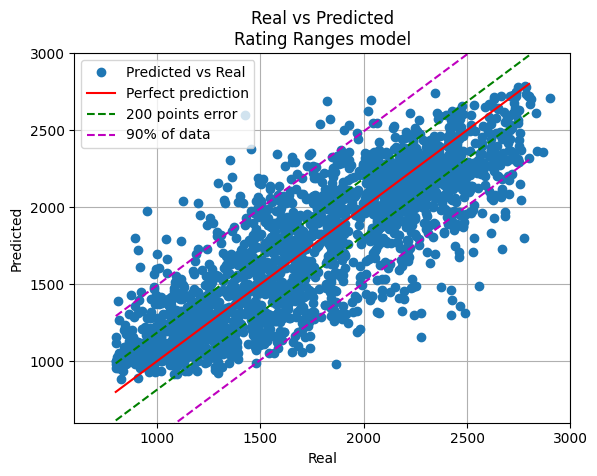

In [31]:
plot_results.compare_results(predictions, y_test)

In [33]:
def rate_predictions(predictions, y_test):
    leeway = 200
    difference = torch.abs(predictions - y_test)
    correct = (difference <= leeway).sum()
    
    return correct.item() / len(predictions)

correct_percentage = rate_predictions(predictions, y_test)
print(f"Correct predictions: {correct_percentage:.3f}")

Correct predictions: 0.535


In [34]:
# If the results are acceptable, save the model
torch.save(lstm_model.state_dict(), f"temp/{position_type}.pt")

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
